In [6]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import pickle

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [7]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)


x_whole_obs = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole_obs = pd.concat([y_train_obs_combined, y_val_obs_combined])

x_whole_est = pd.concat([X_train_est_combined, X_val_est_combined])
y_whole_est = pd.concat([y_train_est_combined, y_val_est_combined])

x_whole_est.head(10)

After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 58), X_test_estimated_b_processed.shape = (720, 58), X_test_estimated_c_processed.shape = (720, 58)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,direct_rad_cloud_interaction,is_freezing,is_snow,is_rain
30068,6.900,1.26900,1.654025e+03,0.000000,2871.250000,0.0,278.450012,0.000000,3816.800049,0.000000,0.000000,27.200001,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1020.875000,0.0,0.0,1008.049988,1014.250000,0.000000,0.0,82.650002,1020.450012,0.0,0.0,0.0,239.816254,0.000,280.524994,35.200001,39068.875000,1.100,0.550,0.950,0.0,1,0,0,-0.737943,0.674863,-0.707107,-0.707107,0.000000,0.000000,0.000000,0,0.772727,0,0.000000,0.000000,0,0,0
32683,3.775,1.27950,7.385284e+05,163.850006,681.250000,0.0,269.825012,83.225006,318197.500000,42.950001,274824.093750,79.074997,0.000,0.000,0.000,0.00,0.000,1.00,0.00,1014.349976,0.0,0.0,1001.049988,1007.325012,0.000000,0.0,65.500000,1013.599976,0.0,0.0,0.0,224.040497,0.000,273.875000,79.074997,28104.949219,8.000,6.000,-5.300,0.0,1,0,0,0.867099,0.498137,-0.500000,-0.866025,3574.514160,0.213666,0.372124,0,1.000000,1,126.175003,898.728882,0,0,0
31298,2.500,1.30150,0.000000e+00,0.000000,1939.224976,0.0,264.625000,0.000000,0.000000,0.000000,0.000000,100.000000,0.150,0.150,0.150,0.15,0.150,0.00,1.00,1010.549988,0.0,0.0,997.349976,1003.650024,0.000000,0.0,59.200001,1010.049988,0.0,0.0,0.3,320.041260,0.100,269.849976,100.000000,11110.724609,5.600,-5.575,0.600,0.0,1,0,0,0.051584,0.998669,-0.707107,0.707107,0.000000,0.000000,0.000000,0,1.000000,1,0.000000,0.000000,1,1,0
96801,4.250,1.26900,0.000000e+00,0.000000,389.500000,0.0,271.549988,0.000000,0.000000,0.000000,0.000000,74.199997,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1013.599976,0.0,0.0,998.099976,1004.275024,0.000000,0.0,62.700001,1010.474976,0.0,0.0,0.0,264.199005,0.000,277.500000,87.925003,57794.398438,4.900,-0.975,4.800,0.0,0,0,1,-0.597829,0.801624,-0.965926,-0.258819,0.000000,0.000000,0.000000,0,0.843901,1,0.000000,0.000000,0,0,0
65078,4.575,1.28800,0.000000e+00,0.000000,9417.000000,0.0,272.424988,0.000000,0.000000,0.000000,0.000000,47.924999,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1020.700012,0.0,0.0,1007.400024,1013.700012,0.000000,0.0,66.500000,1020.000000,0.0,0.0,0.0,66.585251,0.000,276.799988,95.850006,51880.398438,3.000,-0.100,2.975,0.0,0,1,0,0.608121,0.793844,0.707107,0.707107,0.000000,0.000000,0.000000,0,0.500000,1,0.000000,0.000000,0,0,0
65140,3.350,1.27825,0.000000e+00,0.000000,1488.900024,0.0,268.325012,0.000000,0.000000,0.000000,0.000000,100.000000,6.575,1.725,9.075,4.45,4.875,0.00,1.00,998.924988,0.1,3.0,985.650024,991.849976,0.000000,0.0,76.000000,998.150024,0.0,0.0,1.3,261.451508,0.075,271.799988,100.000000,2295.149902,1.925,-1.500,1.150,0.0,0,1,0,0.635068,0.772456,-0.965926,-0.258819,0.000000,0.000000,0.000000,0,1.000000,1,0.000000,0.000000,1,1,1
97694,4.625,1.27125,0.000000e+00,0.000000,4061.900146,-1.0,272.475006,0.000000,0.000000,0.000000,0.000000,61.525002,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1002.299988,0.0,0.0,986.950012,993.099976,27.575001,0.0,83.199997,999.325012,0.0,0.0,0.0,79.674248,0.000,278.600006,98.949997,43315.601562,1.600,-0.400,1.575,0.0,0,0,1,0.711276,0.702913,0.866025,0.500000,0.000000,0.000000,0.000000,0,0.621779,1,0.000000,0.000000,0,0,0
34004,5.000,1.26450,1

In [8]:
x_whole["time_since_prediction"].describe()

count    87876.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: time_since_prediction, dtype: float64

In [9]:
x_whole["pv_measurement"] = y_whole
df_shuffled = x_whole.sample(frac=1, random_state=42).reset_index(drop=True)
x_whole_a = df_shuffled[df_shuffled['location_a'] == 1]
x_whole_b = df_shuffled[df_shuffled['location_b'] == 1]
x_whole_c = df_shuffled[df_shuffled['location_c'] == 1]

y_whole_a = x_whole_a["pv_measurement"]
x_whole_a = x_whole_a.drop("pv_measurement", axis = 1)
x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

y_whole_b = x_whole_b["pv_measurement"]
x_whole_b = x_whole_b.drop("pv_measurement", axis = 1)
x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

y_whole_c = x_whole_c["pv_measurement"]
x_whole_c = x_whole_c.drop("pv_measurement", axis = 1)
x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)
cat_features = ["time_since_prediction", "is_snow", "is_freezing", "is_rain", "is_day:idx", "cloud_cover_over_30%", "is_in_shadow:idx"]

In [10]:
best_model_a = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features
)
best_model_a.fit(x_whole_a, y_whole_a)

Learning rate set to 0.07149
0:	learn: 1100.5746601	total: 37.5ms	remaining: 37.4s
1:	learn: 1039.5264208	total: 78ms	remaining: 38.9s
2:	learn: 983.2057228	total: 116ms	remaining: 38.6s
3:	learn: 931.0820930	total: 153ms	remaining: 38.1s
4:	learn: 883.2597025	total: 187ms	remaining: 37.2s
5:	learn: 839.1246609	total: 222ms	remaining: 36.8s
6:	learn: 799.6206267	total: 261ms	remaining: 37.1s
7:	learn: 763.2740962	total: 298ms	remaining: 37s
8:	learn: 729.8575726	total: 341ms	remaining: 37.6s
9:	learn: 699.3333025	total: 387ms	remaining: 38.3s
10:	learn: 671.6200739	total: 435ms	remaining: 39.1s
11:	learn: 647.1038853	total: 480ms	remaining: 39.5s
12:	learn: 624.5271552	total: 525ms	remaining: 39.8s
13:	learn: 603.8673507	total: 565ms	remaining: 39.8s
14:	learn: 585.5476053	total: 612ms	remaining: 40.2s
15:	learn: 568.6768624	total: 658ms	remaining: 40.5s
16:	learn: 553.5554750	total: 701ms	remaining: 40.5s
17:	learn: 539.5214410	total: 746ms	remaining: 40.7s
18:	learn: 526.7313644	tota

In [11]:
x_whole_a["time_since_prediction"].describe()

count    34046.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: time_since_prediction, dtype: float64

                           Feature  Importance
50                    sun_addition   13.809054
44                     sun_product    5.132524
41                 cos_day_of_year    4.315499
40                 sin_day_of_year    3.973345
7                    diffuse_rad:W    3.936155
9                     direct_rad:W    3.909030
51    direct_rad_cloud_interaction    3.851773
37             wind_speed_u_10m:ms    3.743527
45        modified_solar_elevation    3.157177
38             wind_speed_v_10m:ms    2.992246
3                  clear_sky_rad:W    2.971657
36               wind_speed_10m:ms    2.858930
46             effective_radiation    2.850540
31                   sun_azimuth:d    2.824424
10                 direct_rad_1h:J    2.791733
42                        sin_hour    2.749958
2            clear_sky_energy_1h:J    2.618812
8                 diffuse_rad_1h:J    2.617046
4                 cloud_base_agl:m    2.538078
26     relative_humidity_1000hPa:p    2.170678
33           

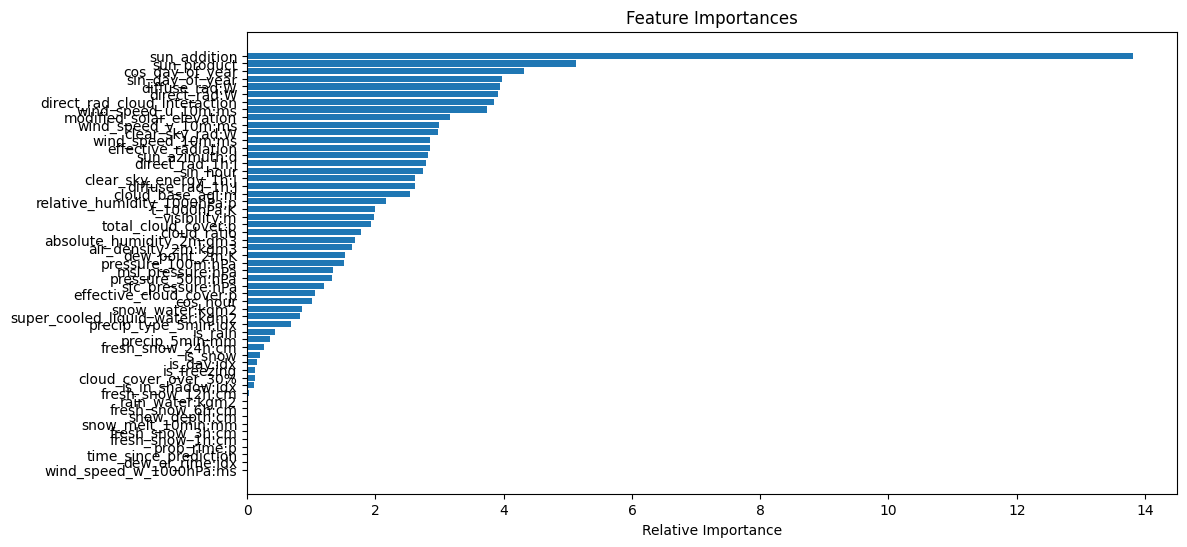

In [12]:
feature_importances = best_model_a.get_feature_importance()

# Get feature names
feature_names = x_whole_a.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [13]:
best_model_b = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features
)
best_model_b.fit(x_whole_b, y_whole_b)

Learning rate set to 0.069582
0:	learn: 192.4791204	total: 37ms	remaining: 36.9s
1:	learn: 181.3319427	total: 70.8ms	remaining: 35.3s
2:	learn: 171.0877499	total: 103ms	remaining: 34.3s
3:	learn: 161.7681811	total: 138ms	remaining: 34.3s
4:	learn: 153.0915593	total: 170ms	remaining: 33.8s
5:	learn: 145.1314195	total: 209ms	remaining: 34.6s
6:	learn: 137.6832571	total: 243ms	remaining: 34.5s
7:	learn: 130.9831891	total: 280ms	remaining: 34.7s
8:	learn: 124.6883628	total: 317ms	remaining: 35s
9:	learn: 118.9283428	total: 350ms	remaining: 34.7s
10:	learn: 113.6252850	total: 384ms	remaining: 34.6s
11:	learn: 108.8091630	total: 420ms	remaining: 34.6s
12:	learn: 104.3231131	total: 456ms	remaining: 34.6s
13:	learn: 100.3022895	total: 491ms	remaining: 34.5s
14:	learn: 96.5836826	total: 529ms	remaining: 34.7s
15:	learn: 93.2067093	total: 565ms	remaining: 34.7s
16:	learn: 90.2278447	total: 599ms	remaining: 34.6s
17:	learn: 87.4700962	total: 638ms	remaining: 34.8s
18:	learn: 84.9415481	total: 682

                           Feature  Importance
50                    sun_addition   12.385816
45        modified_solar_elevation   11.461934
3                  clear_sky_rad:W    7.059902
9                     direct_rad:W    4.273794
44                     sun_product    4.105544
7                    diffuse_rad:W    3.743508
4                 cloud_base_agl:m    3.584225
38             wind_speed_v_10m:ms    2.917989
37             wind_speed_u_10m:ms    2.903391
40                 sin_day_of_year    2.891978
8                 diffuse_rad_1h:J    2.769147
41                 cos_day_of_year    2.668131
2            clear_sky_energy_1h:J    2.357189
35                    visibility:m    2.303333
26     relative_humidity_1000hPa:p    2.293768
36               wind_speed_10m:ms    2.086037
48                     cloud_ratio    2.066226
6                   dew_point_2m:K    2.038596
33                     t_1000hPa:K    1.879908
31                   sun_azimuth:d    1.873919
42           

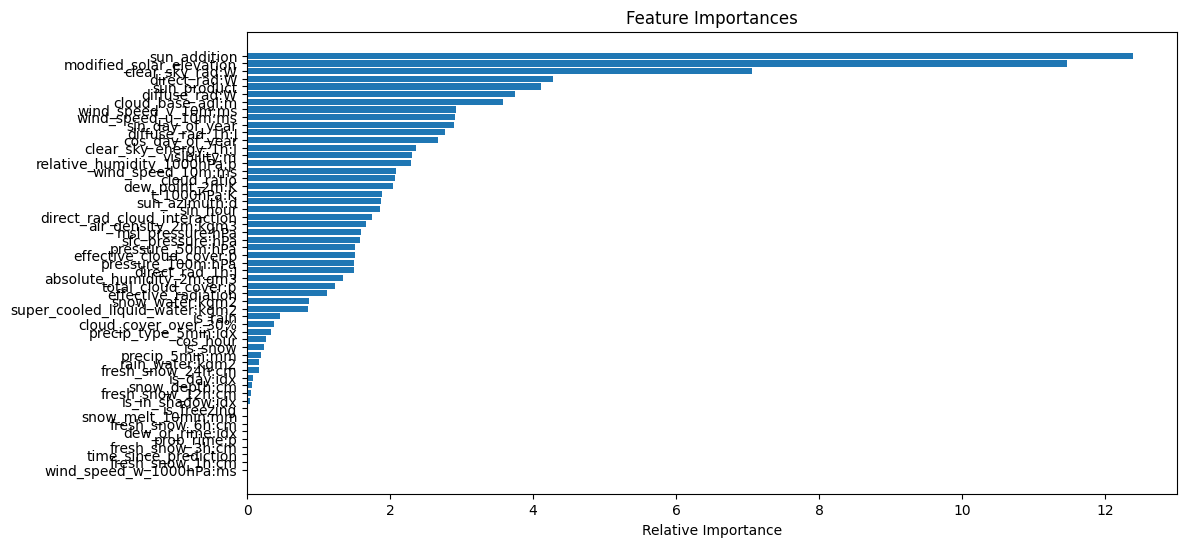

In [14]:
feature_importances = best_model_b.get_feature_importance()

# Get feature names
feature_names = x_whole_b.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [15]:
best_model_c = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features
)
best_model_c.fit(x_whole_c, y_whole_c)

Learning rate set to 0.068146
0:	learn: 158.6036991	total: 33.7ms	remaining: 33.7s
1:	learn: 149.7570212	total: 67.9ms	remaining: 33.9s
2:	learn: 141.7259762	total: 105ms	remaining: 34.9s
3:	learn: 134.2089481	total: 141ms	remaining: 35s
4:	learn: 126.9710675	total: 181ms	remaining: 36s
5:	learn: 120.4024235	total: 219ms	remaining: 36.4s
6:	learn: 114.4414556	total: 262ms	remaining: 37.2s
7:	learn: 108.7959824	total: 297ms	remaining: 36.9s
8:	learn: 103.5615623	total: 335ms	remaining: 36.9s
9:	learn: 98.8370948	total: 373ms	remaining: 36.9s
10:	learn: 94.5184101	total: 410ms	remaining: 36.8s
11:	learn: 90.5421790	total: 444ms	remaining: 36.6s
12:	learn: 86.9043614	total: 483ms	remaining: 36.7s
13:	learn: 83.5974501	total: 523ms	remaining: 36.8s
14:	learn: 80.5957151	total: 563ms	remaining: 36.9s
15:	learn: 77.8124819	total: 599ms	remaining: 36.9s
16:	learn: 75.2258676	total: 640ms	remaining: 37s
17:	learn: 72.8808844	total: 680ms	remaining: 37.1s
18:	learn: 70.7078920	total: 715ms	rema

                           Feature  Importance
50                    sun_addition   12.615635
45        modified_solar_elevation    6.219113
2            clear_sky_energy_1h:J    5.908345
3                  clear_sky_rad:W    5.470511
8                 diffuse_rad_1h:J    4.475612
7                    diffuse_rad:W    4.199767
44                     sun_product    4.139422
9                     direct_rad:W    4.029529
33                     t_1000hPa:K    3.869894
37             wind_speed_u_10m:ms    3.423596
40                 sin_day_of_year    3.411734
10                 direct_rad_1h:J    3.176669
51    direct_rad_cloud_interaction    2.780037
41                 cos_day_of_year    2.688184
36               wind_speed_10m:ms    2.370705
38             wind_speed_v_10m:ms    2.289884
48                     cloud_ratio    2.184740
26     relative_humidity_1000hPa:p    2.136935
1              air_density_2m:kgm3    1.986165
6                   dew_point_2m:K    1.909730
34           

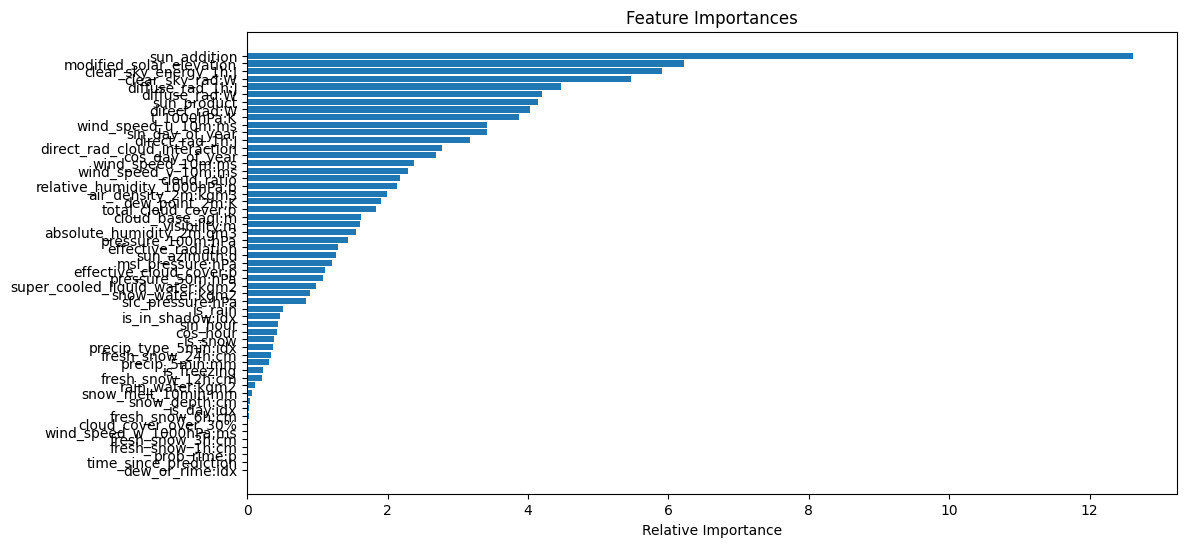

In [16]:
feature_importances = best_model_c.get_feature_importance()

# Get feature names
feature_names = x_whole_c.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [17]:
x_whole_a = x_test_whole[x_test_whole['location_a'] == 1]
x_whole_b = x_test_whole[x_test_whole['location_b'] == 1]
x_whole_c = x_test_whole[x_test_whole['location_c'] == 1]

x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [18]:
y_pred_a = best_model_a.predict(x_whole_a)
y_pred_b = best_model_b.predict(x_whole_b)
y_pred_c = best_model_c.predict(x_whole_c)
y_pred = pd.concat([pd.Series(y_pred_a), pd.Series(y_pred_b), pd.Series(y_pred_c)])
y_pred = y_pred.reset_index(drop=True)
# Save the model
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data

y_pred = postprocess_data(x_test_whole, pd.DataFrame(y_pred))
save_predictions(y_pred, 'catboost flere features')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_